In [2]:
!pip install -q scikit-fuzzy


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

In [ ]:
asd


In [ ]:
class Fuzzy:
    def __init__(self, urgency, budget, predict_cost, predict_time):
        self.urg = np.linspace(0,10,100)
        self.bud = np.linspace(0,10,100)
        self.cost = np.arange(0,35.1, 0.1)
        self.time = np.arange(0,220.1, 0.1)
        self.comfort_score = np.linspace(0,100, 1001)

        self.urgency = urgency
        self.budget = budget
        self.predict_Cost = predict_cost
        self.predict_Time = predict_time
        
        self.define_mfs_degrees(self.urg, self.bud, self.cost, self.time, self.comfort_score, self.urgency, self.budget, self.predict_Cost, self.predict_Time)
        
        self.define_rules()
        self.plot_defuzz()
    def define_mfs_degrees(self, urg, bud, cost, time, comfort_score, urgency, budget, predict_Cost, predict_Time):
        #input urgency
        self.urg_low = fuzz.trapmf(urg, [0, 0, 2, 4])
        self.urg_medium = fuzz.trimf(urg, [3, 5, 7])
        self.urg_high = fuzz.trapmf(urg, [6, 6, 10, 10])

        #input budget
        self.bud_low = fuzz.trapmf(bud, [0, 0, 2, 4])
        self.bud_medium = fuzz.trimf(bud, [3, 5, 7])
        self.bud_high = fuzz.trapmf(bud, [6, 6, 10, 10])
        
        #input cost
        self.cost_low = fuzz.trapmf(cost, [0, 0, 4, 7])
        self.cost_medium = fuzz.trimf(cost, [6, 10, 15])
        self.cost_high = fuzz.trapmf(cost, [14, 18, 30, 30])
        
        #input time
        self.time_low = fuzz.trapmf(time, [0, 0, 30, 60])
        self.time_medium = fuzz.trimf(time, [55, 85, 105])
        self.time_high = fuzz.trapmf(time, [100, 135, 190, 215])
        
        #output comfort score
        self.comfort_low = fuzz.trapmf(comfort_score, [0,0,20,40])
        self.comfort_medium = fuzz.trimf(comfort_score, [30, 50, 70])
        self.comfort_high = fuzz.trapmf(comfort_score, [60, 60, 100, 100])
        
        #membership degrees
        #budget
        self.bl_lvl = fuzz.interp_membership(bud, self.bud_low, budget)
        self.bm_lvl = fuzz.interp_membership(bud, self.bud_medium, budget)
        self.bh_lvl = fuzz.interp_membership(bud, self.bud_high, budget)
        #urgency
        self.ul_lvl = fuzz.interp_membership(urg, self.urg_low, urgency)
        self.um_lvl = fuzz.interp_membership(urg, self.urg_medium, urgency)
        self.uh_lvl = fuzz.interp_membership(urg, self.urg_high, urgency)
        #time
        self.tl_lvl = fuzz.interp_membership(time, self.time_low, predict_Time)
        self.tm_lvl = fuzz.interp_membership(time, self.time_medium, predict_Time)
        self.th_lvl = fuzz.interp_membership(time, self.time_high, predict_Time)
        #cost
        self.cl_lvl = fuzz.interp_membership(cost, self.cost_low, predict_Cost)
        self.cm_lvl = fuzz.interp_membership(cost, self.cost_medium, predict_Cost)
        self.ch_lvl = fuzz.interp_membership(cost, self.cost_high, predict_Cost)
        """ print(f
        Budget Levels:   Low={self.bl_lvl:.3f}, Medium={self.bm_lvl:.3f}, High={self.bh_lvl:.3f}
        Urgency Levels:  Low={self.ul_lvl:.3f}, Medium={self.um_lvl:.3f}, High={self.uh_lvl:.3f}
        Time Levels:     Low={self.tl_lvl:.3f}, Medium={self.tm_lvl:.3f}, High={self.th_lvl:.3f}
        Cost Levels:     Low={self.cl_lvl:.3f}, Medium={self.cm_lvl:.3f}, High={self.ch_lvl:.3f}
        ) """
        return (self.bl_lvl, self.bm_lvl, self.bh_lvl, 
                self.ul_lvl, self.um_lvl, self.uh_lvl,
                self.tl_lvl, self.tm_lvl, self.th_lvl, 
                self.cl_lvl, self.cm_lvl, self.ch_lvl)
    def define_rules(self):
        #low
        #r1: if budget sensitivity is low, and urgency is low, then comfort it high
        self.r1 = np.fmin(np.fmin(self.bl_lvl, self.ul_lvl), self.comfort_high)
        
        #r2: if budget sensitivity is high, and urgency is high then comfort is low
        self.r2 = np.fmin(np.fmin(self.bh_lvl, self.uh_lvl), self.comfort_low)
        
        #r3: if budget is low and cost is high then the comfort is low too
        self.r3 = np.fmin(np.fmin(self.bh_lvl, self.cl_lvl), self.comfort_low)
        
        #r3: if time is high, and urgency is high then comfort is low
        self.r4 = np.fmin(np.fmin(self.th_lvl, self.uh_lvl), self.comfort_low)
        
        
        #medium
        #r4: if budget sensitivity is medium, and urgency is medium, then comfort it medium
        self.r5 = np.fmin(np.fmin(self.bm_lvl, self.um_lvl), self.comfort_medium)
        
        #r6: if budget sensitivity is high, and cost is medium then comfort is medium
        self.r6 = np.fmin(np.fmin(self.bh_lvl, self.ch_lvl), self.comfort_medium)
        
        #r7: if urgency is medium and time is medium then the comfort is medium too
        self.r7 = np.fmin(np.fmin(self.um_lvl, self.tm_lvl), self.comfort_medium)
        
        #r8: if budget is low and cost is low, then comfort is medium
        self.r8 = np.fmin(np.fmin(self.th_lvl, self.uh_lvl), self.comfort_medium)
        
        #r9: urgency is low and time is high then comfort is medium
        self.r9 = np.fmin(np.fmin(self.ul_lvl, self.th_lvl), self.comfort_medium)
        
        #r10: if cost is high and budget is medium then comfort is medium
        self.r10 = np.fmin(np.fmin(self.ch_lvl, self.bm_lvl), self.comfort_medium)
        
        
        #high
        #r11: if budget is high and cost is low then comfort is high
        self.r11 = np.fmin(np.fmin(self.bh_lvl, self.cl_lvl), self.comfort_high)
        
        #r12: if urgency is low and time is low then comfort is high
        self.r12 = np.fmin(np.fmin(self.ul_lvl, self.tl_lvl), self.comfort_high)
        
        #r13: if budget is medium and cost is low then comfort is high
        self.r13 = np.fmin(np.fmin(self.bm_lvl, self.cl_lvl), self.comfort_high)

        #r14: if urgency is low and cost is low then comfort is high
        self.r14 = np.fmin(np.fmin(self.ul_lvl, self.cl_lvl), self.comfort_high)
        
        #r15: if urgency is high and cost is high then comfort is low
        self.r15 = np.fmin(np.fmin(self.uh_lvl, self.ch_lvl), self.comfort_low)
        
        #r16: if budget is low, urgency is medium and time is mediun then comfort is medium
        self.r16 = np.fmin(np.fmin(self.tm_lvl, np.fmin(self.bl_lvl, self.um_lvl)), self.comfort_medium)
        #aggregate everything
        self.aggregated = np.fmax(
            np.fmax(
                np.fmax(
                    np.fmax(self.r1, self.r2),
                    np.fmax(self.r3, self.r4)
                ),
                np.fmax(
                    np.fmax(self.r5, self.r6),
                    np.fmax(self.r7, self.r8)
                )
            ),
            np.fmax(
                np.fmax(
                    np.fmax(self.r9, self.r10),
                    np.fmax(self.r11, self.r12)
                ),
                np.fmax(
                    np.fmax(self.r13, self.r14),
                    np.fmax(self.r15, self.r16)
                )
            )
        )
    def plot_defuzz(self):
        #defuzz
        if np.all(self.aggregated == 0):
            centroid = None
            mom = None
        else:
            centroid = fuzz.defuzz(self.comfort_score, self.aggregated, "centroid")
            mom = fuzz.defuzz(self.comfort_score, self.aggregated, "mom")
        print(f"Comfort Score (Centroid): {None if centroid is None else round(centroid, 2)}")
        print(f"Comfort score (mom) {None if mom is None else round(mom,2)}")
        # --- Plot base output MFs and aggregated result
        plt.figure(figsize=(7,4))
        plt.plot(self.comfort_score, self.comfort_low, '--', label='Low (base)')
        plt.plot(self.comfort_score, self.comfort_medium,      '--', label='Medium (base)')
        plt.plot(self.comfort_score, self.comfort_high,      '--', label='High (base)')
        plt.fill_between(self.comfort_score, 0, self.aggregated, alpha=0.6, label='Aggregated Output')
        plt.title('Aggregated Output: Comfort Score')
        plt.xlabel('Comfort (0–10)')
        plt.ylabel('Membership')
        plt.legend()
        plt.grid(True)
        plt.show()
    def defuzz(self):
        if np.all(self.aggregated == 0):
            self.centroid = None
            self.mom = None
        else:
            self.centroid = fuzz.defuzz(self.comfort_score, self.aggregated, "centroid")
            self.mom = fuzz.defuzz(self.comfort_score, self.aggregated, "mom")
        return self.mom



        Budget Levels:   Low=0.012, Medium=0.500, High=0.000
        Urgency Levels:  Low=1.000, Medium=0.000, High=0.000
        Time Levels:     Low=1.000, Medium=0.000, High=0.000
        Cost Levels:     Low=0.000, Medium=0.000, High=0.250
        
Comfort Score (Centroid): 75.03
Comfort score (mom) 80.0


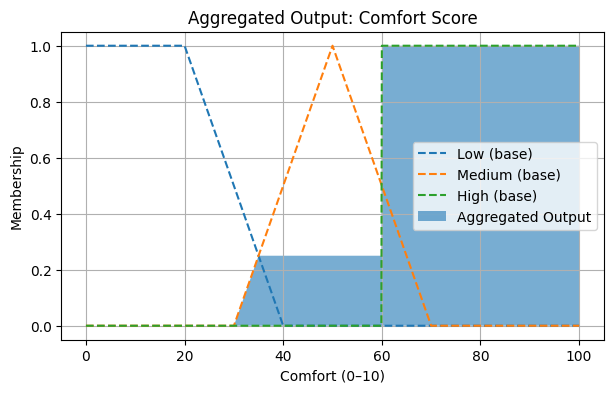

80.0


In [6]:
fz = Fuzzy(urgency=0, budget=4, predict_cost=15, predict_time=15)
mom = fz.defuzz()
print(mom)

In [9]:
# ============================================================
# Reinforcement Learning Agent for Student Performance Support
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import joblib
from tqdm import tqdm


class ActionRecommender:
    def __init__(self, data_path):
        self.df = joblib.load(f"..{data_path}")

        required_cols = [
            "Battery Capacity (kWh)",
            "Charging Station Location_Chicago",
            "Charging Station Location_Houston",
            "Charging Station Location_Los Angeles",
            "Charging Station Location_New York",
            "Charging Station Location_San Francisco",
            "Charger Type",
            "Time of Day"
        ]
        
        self.ACTION_NAMES = {}
        self.n_actions = None
    def preprocess_Train(self):
        # Discretizing Continuous features
        self.df["Battery_Level"] = pd.qcut(self.df["Battery Capacity (kWh)"], 2, labels=[0, 1]).astype(int)
        location_cols = [
            "Charging Station Location_Chicago",
            "Charging Station Location_Houston",
            "Charging Station Location_Los Angeles",
            "Charging Station Location_New York",
            "Charging Station Location_San Francisco"
        ]
        self.df["Location_State"] = self.df[location_cols].idxmax(axis=1).str.replace("Charging Station Location_", "")
        location_mapping = {
            "Chicago": 0,
            "Houston": 1,
            "Los Angeles": 2,
            "New York": 3,
            "San Francisco": 4
        }
        self.df["Location_State"] = self.df["Location_State"].map(location_mapping)
        
        self.df["State"] = list(
            zip(
                self.df["Battery_Level"],
                self.df["Location_State"],
                self.df["Charger Type"],
                self.df["Time of Day"]
            )
        )
        self.ACTION_NAMES = {
            0: "Do Nothing",
            1: "Recommend Changing Location",
            2: "Delay Charging"
        }
        self.n_actions = 3

        self.df["Reward"] = 2 - (self.df["Charging Cost (USD)"] * 3)
        self.states = list(itertools.product([0,1],
                                [0,1,2,3,4],
                                [0,1,2],
                                [0,1,2,3], repeat=1))
        self.state_to_index = {s: i for i, s in enumerate(self.states)}
        self.n_states = len(self.states)
        self.Q = np.zeros((self.n_states, self.n_actions))

        # ============================================================
        # 6. Q-learning Hyperparameters
        # ============================================================
        episodes = 10000
        alpha = 0.2
        gamma = 0.0        # single-step learning
        epsilon = 1.0
        epsilon_min = 0.05
        epsilon_decay = 0.97

        reward_history = []
        q_history = []

        # Group data for fast reward sampling
        grouped = {}
        for s in self.states:
            for a in range(self.n_actions):
                grouped[(s, a)] = self.df[self.df["State"] == s]
        # Initialize progress bar
        pbar = tqdm(range(episodes), desc="Training RL Agent")

        for ep in pbar:

            # Random state (offline RL from dataset)
            s = random.choice(self.states)
            s_idx = self.state_to_index[s]

            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                a = np.random.randint(self.n_actions)
            else:
                a = int(np.argmax(self.Q[s_idx]))

            # Reward sampling
            candidates = grouped[(s, a)]
            if len(candidates) == 0:
                r = 0.0
            else:
                r = float(candidates.sample(1)["Reward"].iloc[0])

            # Q update
            self.Q[s_idx, a] += alpha * (r - self.Q[s_idx, a])

            reward_history.append(r)
            q_history.append(self.Q.copy())

            epsilon = max(epsilon_min, epsilon * epsilon_decay)

    def recommend_action(self, battery_capacity, location_idx, charger_type, time_of_day):
        """
        Input raw student values
        Output recommended action name
        """

        # Convert input to low(0) / high(1) using dataset medians
        battery_level  = int(battery_capacity >= self.df["Battery Capacity (kWh)"].median())
        # Create location one-hot
        location_one_hot = [0, 0, 0, 0, 0]
        location_one_hot[location_idx] = 1

        state = (
            battery_level,
            location_idx,
            int(charger_type),
            int(time_of_day)
        )


        if state not in self.state_to_index:
            print(f"Warning: State {state} not found in training data.")
            print(f"Available states: {len(self.state_to_index)}")
            return "Do Nothing"  # Default action
        state_idx = self.state_to_index[state]
        best_action = int(np.argmax(self.Q[state_idx]))

        return self.ACTION_NAMES[best_action]

In [ ]:
recommender = ActionRecommender(data_path=r"\data\preprocessed_encoded_data.pkl")

recommender.preprocess_Train()


action = recommender.recommend_action(
    battery_capacity=20, 
    location_idx=0, 
    charger_type=1, 
    time_of_day=2
)

print(f"Test Result Action: {action}")


Training RL Agent: 100%|██████████| 10000/10000 [00:02<00:00, 3739.95it/s]

------------------------------
Test Result Action: Recommend Changing Location
------------------------------
